In [2]:
import numpy as np
from skimage.transform import resize
from keras.models import load_model
import pylidc as pl
from sklearn.model_selection import train_test_split
from unet import UNet

/usr/share/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
scans = pl.query(pl.Scan)
n = scans.count()

In [4]:
image_size = (256, 256)

In [5]:
def get_data(i, only_nodules=True):
    scan = scans[i]
    images = scan.load_all_dicom_images(verbose=False)
    n = len(images)
    X = np.array([resize(im.pixel_array, image_size, mode='constant') for im in images])
    X = np.expand_dims(X, axis=-1)
    y = np.zeros((512, 512, n))
    for ann in scan.annotations:
        b = ann.bbox()
        y[b] = np.logical_or(y[b], ann.boolean_mask())
    y = np.rollaxis(y, 2, 0)
    y = resize(y, (n, *image_size), mode='constant')
    if only_nodules:
        indices = [l.sum() > 0 for l in y]
        X = X[indices]
        y = y[indices]
    y = np.expand_dims(y, axis=-1)
    return X, y

In [7]:
train, test = train_test_split(range(n))

In [10]:
model = UNet((*image_size, 1), batchnorm=True, dropout=False)
model.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
for _ in range(500):
    while True:
        i = np.random.choice(train)
        print(i)
        try:
            X, y = get_data(i)
            if len(X):
                model.fit(X, y, batch_size=1, epochs=3)
                break
            else:
                print('No nodules!')
        except OSError:
            print('Problem getting data')

133
Epoch 1/3
23/23 [==============================] - 8s 326ms/step - loss: 0.0031 - acc: 0.9991
Epoch 2/3
23/23 [==============================] - 7s 319ms/step - loss: 0.0014 - acc: 0.9995
Epoch 3/3
23/23 [==============================] - 7s 326ms/step - loss: 0.0010 - acc: 0.9996
211
Epoch 1/3
25/25 [==============================] - 8s 313ms/step - loss: 0.0023 - acc: 0.9992
Epoch 2/3
25/25 [==============================] - 8s 313ms/step - loss: 0.0010 - acc: 0.9995
Epoch 3/3
25/25 [==============================] - 8s 313ms/step - loss: 9.5158e-04 - acc: 0.9995
961
Epoch 1/3
3/3 [==============================] - 1s 318ms/step - loss: 8.6074e-04 - acc: 0.9999
Epoch 2/3
3/3 [==============================] - 1s 307ms/step - loss: 8.4053e-04 - acc: 0.9999
Epoch 3/3
3/3 [==============================] - 1s 314ms/step - loss: 8.1908e-04 - acc: 0.9999
618
Epoch 1/3
37/37 [==============================] - 12s 322ms/step - loss: 0.0032 - acc: 0.9992
Epoch 2/3
37/37 [================

5/5 [==============================] - 2s 313ms/step - loss: 0.0022 - acc: 0.9996
Epoch 3/3
5/5 [==============================] - 2s 310ms/step - loss: 0.0015 - acc: 0.9996
432
Epoch 1/3
20/20 [==============================] - 7s 327ms/step - loss: 0.0017 - acc: 0.9996
Epoch 2/3
20/20 [==============================] - 6s 312ms/step - loss: 0.0012 - acc: 0.9996
Epoch 3/3
20/20 [==============================] - 6s 312ms/step - loss: 0.0011 - acc: 0.9996
699
Epoch 1/3
7/7 [==============================] - 2s 354ms/step - loss: 0.0012 - acc: 0.9998
Epoch 2/3
7/7 [==============================] - 2s 310ms/step - loss: 9.9920e-04 - acc: 0.9998
Epoch 3/3
7/7 [==============================] - 2s 309ms/step - loss: 8.4554e-04 - acc: 0.9998
225
No nodules!
972
Epoch 1/3
22/22 [==============================] - 7s 324ms/step - loss: 0.0024 - acc: 0.9993
Epoch 2/3
22/22 [==============================] - 7s 311ms/step - loss: 0.0015 - acc: 0.9994
Epoch 3/3
22/22 [===========================

6/6 [==============================] - 2s 310ms/step - loss: 0.0023 - acc: 0.9998
Epoch 2/3
6/6 [==============================] - 2s 311ms/step - loss: 0.0016 - acc: 0.9998
Epoch 3/3
6/6 [==============================] - 2s 316ms/step - loss: 0.0015 - acc: 0.9998
842
Epoch 1/3
2/2 [==============================] - 1s 307ms/step - loss: 0.0014 - acc: 0.9998
Epoch 2/3
2/2 [==============================] - 1s 308ms/step - loss: 0.0014 - acc: 0.9998
Epoch 3/3
2/2 [==============================] - 1s 313ms/step - loss: 0.0013 - acc: 0.9998
48
Epoch 1/3
2/2 [==============================] - 1s 320ms/step - loss: 0.0012 - acc: 0.9998
Epoch 2/3
2/2 [==============================] - 1s 311ms/step - loss: 0.0012 - acc: 0.9998
Epoch 3/3
2/2 [==============================] - 1s 307ms/step - loss: 0.0012 - acc: 0.9998
422
Epoch 1/3
8/8 [==============================] - 2s 312ms/step - loss: 0.0018 - acc: 0.9997
Epoch 2/3
8/8 [==============================] - 2s 311ms/step - loss: 0.0014 -

19/19 [==============================] - 6s 321ms/step - loss: 0.0023 - acc: 0.9995
Epoch 3/3
19/19 [==============================] - 6s 320ms/step - loss: 0.0014 - acc: 0.9996
875
Epoch 1/3
3/3 [==============================] - 1s 307ms/step - loss: 0.0018 - acc: 0.9997
Epoch 2/3
3/3 [==============================] - 1s 317ms/step - loss: 0.0016 - acc: 0.9997
Epoch 3/3
3/3 [==============================] - 1s 310ms/step - loss: 0.0013 - acc: 0.9997
603
Epoch 1/3
9/9 [==============================] - 3s 348ms/step - loss: 8.3296e-04 - acc: 0.9999
Epoch 2/3
9/9 [==============================] - 3s 314ms/step - loss: 6.2866e-04 - acc: 0.9999
Epoch 3/3
9/9 [==============================] - 3s 338ms/step - loss: 5.2064e-04 - acc: 0.9999
172
Epoch 1/3
8/8 [==============================] - 3s 313ms/step - loss: 0.0032 - acc: 0.9988
Epoch 2/3
8/8 [==============================] - 2s 309ms/step - loss: 0.0011 - acc: 0.9995
Epoch 3/3
8/8 [==============================] - 2s 311ms/step

Epoch 3/3
6/6 [==============================] - 2s 335ms/step - loss: 7.3719e-04 - acc: 0.9998
66
Epoch 1/3
15/15 [==============================] - 5s 344ms/step - loss: 0.0020 - acc: 0.9996
Epoch 2/3
15/15 [==============================] - 5s 320ms/step - loss: 0.0015 - acc: 0.9996
Epoch 3/3
15/15 [==============================] - 5s 322ms/step - loss: 0.0010 - acc: 0.9997
152
Epoch 1/3
4/4 [==============================] - 1s 318ms/step - loss: 0.0029 - acc: 0.9990
Epoch 2/3
4/4 [==============================] - 1s 319ms/step - loss: 0.0012 - acc: 0.9994
Epoch 3/3
4/4 [==============================] - 1s 317ms/step - loss: 7.0054e-04 - acc: 0.9996
644
Epoch 1/3
2/2 [==============================] - 1s 306ms/step - loss: 0.0017 - acc: 0.9996
Epoch 2/3
2/2 [==============================] - 1s 313ms/step - loss: 0.0015 - acc: 0.9996
Epoch 3/3
2/2 [==============================] - 1s 307ms/step - loss: 0.0014 - acc: 0.9996
18
Epoch 1/3
5/5 [==============================] - 2s 

10/10 [==============================] - 3s 311ms/step - loss: 6.5424e-04 - acc: 0.9998
431
No nodules!
492
Epoch 1/3
51/51 [==============================] - 16s 319ms/step - loss: 0.0012 - acc: 0.9997
Epoch 2/3
51/51 [==============================] - 16s 319ms/step - loss: 6.3155e-04 - acc: 0.9997
Epoch 3/3
51/51 [==============================] - 16s 322ms/step - loss: 5.1585e-04 - acc: 0.9998
666
No nodules!
358
Epoch 1/3
21/21 [==============================] - 7s 328ms/step - loss: 0.0015 - acc: 0.9996
Epoch 2/3
21/21 [==============================] - 7s 315ms/step - loss: 0.0010 - acc: 0.9997
Epoch 3/3
21/21 [==============================] - 7s 323ms/step - loss: 8.9534e-04 - acc: 0.9997
783
Epoch 1/3
24/24 [==============================] - 8s 316ms/step - loss: 0.0020 - acc: 0.9995
Epoch 2/3
24/24 [==============================] - 8s 320ms/step - loss: 0.0013 - acc: 0.9996
Epoch 3/3
24/24 [==============================] - 8s 327ms/step - loss: 0.0011 - acc: 0.9997
772
Epo

25/25 [==============================] - 8s 327ms/step - loss: 0.0032 - acc: 0.9990
Epoch 2/3
25/25 [==============================] - 8s 313ms/step - loss: 0.0012 - acc: 0.9994
Epoch 3/3
25/25 [==============================] - 8s 317ms/step - loss: 9.6012e-04 - acc: 0.9994
489
Epoch 1/3
8/8 [==============================] - 2s 311ms/step - loss: 0.0046 - acc: 0.9987
Epoch 2/3
8/8 [==============================] - 3s 313ms/step - loss: 0.0023 - acc: 0.9992
Epoch 3/3
8/8 [==============================] - 2s 312ms/step - loss: 0.0017 - acc: 0.9993
255
Epoch 1/3
5/5 [==============================] - 2s 311ms/step - loss: 0.0024 - acc: 0.9991
Epoch 2/3
5/5 [==============================] - 2s 309ms/step - loss: 0.0012 - acc: 0.9997
Epoch 3/3
5/5 [==============================] - 2s 314ms/step - loss: 0.0011 - acc: 0.9997
259
Epoch 1/3
15/15 [==============================] - 5s 312ms/step - loss: 0.0044 - acc: 0.9987
Epoch 2/3
15/15 [==============================] - 5s 316ms/step -

15/15 [==============================] - 5s 313ms/step - loss: 0.0013 - acc: 0.9996
Epoch 3/3
15/15 [==============================] - 5s 316ms/step - loss: 8.6261e-04 - acc: 0.9996
861
Epoch 1/3
15/15 [==============================] - 5s 333ms/step - loss: 0.0015 - acc: 0.9995
Epoch 2/3
15/15 [==============================] - 5s 312ms/step - loss: 8.0962e-04 - acc: 0.9997
Epoch 3/3
15/15 [==============================] - 5s 321ms/step - loss: 6.7725e-04 - acc: 0.9997
90
Epoch 1/3
8/8 [==============================] - 3s 320ms/step - loss: 0.0012 - acc: 0.9998
Epoch 2/3
8/8 [==============================] - 2s 309ms/step - loss: 0.0011 - acc: 0.9998
Epoch 3/3
8/8 [==============================] - 3s 318ms/step - loss: 9.2955e-04 - acc: 0.9998
884
Epoch 1/3
78/78 [==============================] - 25s 320ms/step - loss: 0.0013 - acc: 0.9995
Epoch 2/3
78/78 [==============================] - 25s 320ms/step - loss: 8.2026e-04 - acc: 0.9996
Epoch 3/3
78/78 [==========================

Epoch 3/3
55/55 [==============================] - 17s 314ms/step - loss: 8.2318e-04 - acc: 0.9997
790
Epoch 1/3
9/9 [==============================] - 3s 313ms/step - loss: 0.0017 - acc: 0.9996
Epoch 2/3
9/9 [==============================] - 3s 316ms/step - loss: 0.0013 - acc: 0.9998
Epoch 3/3
9/9 [==============================] - 3s 312ms/step - loss: 0.0013 - acc: 0.9998
139
Epoch 1/3
15/15 [==============================] - 5s 311ms/step - loss: 0.0061 - acc: 0.9985
Epoch 2/3
15/15 [==============================] - 5s 316ms/step - loss: 0.0023 - acc: 0.9990
Epoch 3/3
15/15 [==============================] - 5s 320ms/step - loss: 0.0016 - acc: 0.9993
594
Epoch 1/3
11/11 [==============================] - 4s 342ms/step - loss: 0.0021 - acc: 0.9996
Epoch 2/3
11/11 [==============================] - 3s 314ms/step - loss: 6.1182e-04 - acc: 0.9997
Epoch 3/3
11/11 [==============================] - 3s 313ms/step - loss: 3.9273e-04 - acc: 0.9998
476
No nodules!
903
Epoch 1/3
34/34 [====

16/16 [==============================] - 5s 312ms/step - loss: 0.0019 - acc: 0.9993
Epoch 2/3
16/16 [==============================] - 5s 319ms/step - loss: 7.9760e-04 - acc: 0.9996
Epoch 3/3
16/16 [==============================] - 5s 323ms/step - loss: 5.0203e-04 - acc: 0.9997
823
Epoch 1/3
4/4 [==============================] - 2s 388ms/step - loss: 0.0012 - acc: 0.9997
Epoch 2/3
4/4 [==============================] - 1s 315ms/step - loss: 9.5687e-04 - acc: 0.9997
Epoch 3/3
4/4 [==============================] - 1s 306ms/step - loss: 6.0057e-04 - acc: 0.9998
962
Epoch 1/3
3/3 [==============================] - 1s 308ms/step - loss: 0.0034 - acc: 0.9990
Epoch 2/3
3/3 [==============================] - 1s 319ms/step - loss: 0.0018 - acc: 0.9995
Epoch 3/3
3/3 [==============================] - 1s 306ms/step - loss: 0.0014 - acc: 0.9996
155
Epoch 1/3
5/5 [==============================] - 2s 309ms/step - loss: 0.0011 - acc: 0.9996
Epoch 2/3
5/5 [==============================] - 2s 308m

In [31]:
model.save('unet.hdf5')

In [32]:
from sklearn.externals import joblib
joblib.dump(test, 'test_set.p')

['test_set.p']

In [13]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline

In [48]:
X, y = get_data(np.random.choice(test), only_nodules=False)
preds = model.predict(X, batch_size=1)
fpr, tpr, _ = roc_curve(np.rint(y).flatten(), preds.flatten())

In [49]:
auc(fpr, tpr)

0.9925802742786933

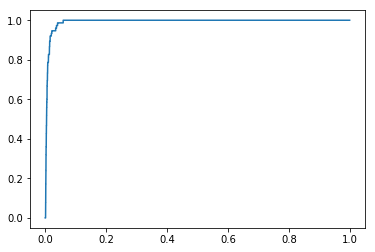

In [50]:
plt.plot(fpr, tpr)